In [1]:
import re
import glob
import pickle
import pandas as pd
import numpy as np
import requests as r
import seaborn as sns
import matplotlib.pyplot as plt
from json import dump, dumps
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, PassiveAggressiveClassifier, Perceptron

## Source Data

IF source data is missing run Elasticsearch query to extract data and then save it in JSON format to `data` directory

In [2]:
news_json = r.get('http://ip-172-30-0-236:9200/slashnews/scraped/_search?sort=date:desc&size=4000').json()
with open('./data/news.json', 'w', encoding='utf8') as fh:
  dump(news_json['hits']['hits'], fh)

In [3]:
df = pd.io.json.json_normalize(news_json['hits']['hits'])
df.to_json('./data/news.json')

In [4]:
df = pd.read_json('./data/news.json')

## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [5]:
df = df[['_source.body', '_source.date', '_source.subject', '_source.language', '_source.categories']]
df.columns = ['body', 'pubdate', 'subject', 'language', 'categories']

In [6]:
df.drop_duplicates(inplace=True)
df.head(1).T.style

In [7]:
df = df.loc[(df['categories'] != 'News') & 
            (df['categories'] != 'articles 2015') & 
            (df['categories'] != 'frontpage') &
            (df['language'] == 'English')]

In [8]:
df['categories'] = df['categories'].str.replace(r'[^a-zA-Z_, ]+', '').replace(', ', '')
df['categories'] = df['categories'].str.replace(r'^, ', '')

In [9]:
df.groupby(['categories']).agg({'count'}).drop_duplicates()

,body,pubdate,subject,language
,count,count,count,count
categories,,,,
"family and medical leave act, blue collar workers, go fund me",1,1,1,1
Activism,3,3,3,3
"Advocacy, Disinformation, Feature",2,2,2,2
Africa,4,4,4,4
"Africa, Algeria, News",13,13,13,13
"Africa, Egypt, Europe Russia",6,6,6,6
"Africa, Egypt, News",17,17,17,17
"Africa, Europe Russia, Libya",14,14,14,14


In [10]:
df['cat_id']       = df['categories'].factorize()[0]
df['lang_id']      = df['language'].factorize()[0]
df['char_count']   = df['body'].apply(len)
df['word_count']   = df['body'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)

In [11]:
df.shape

(2367, 10)

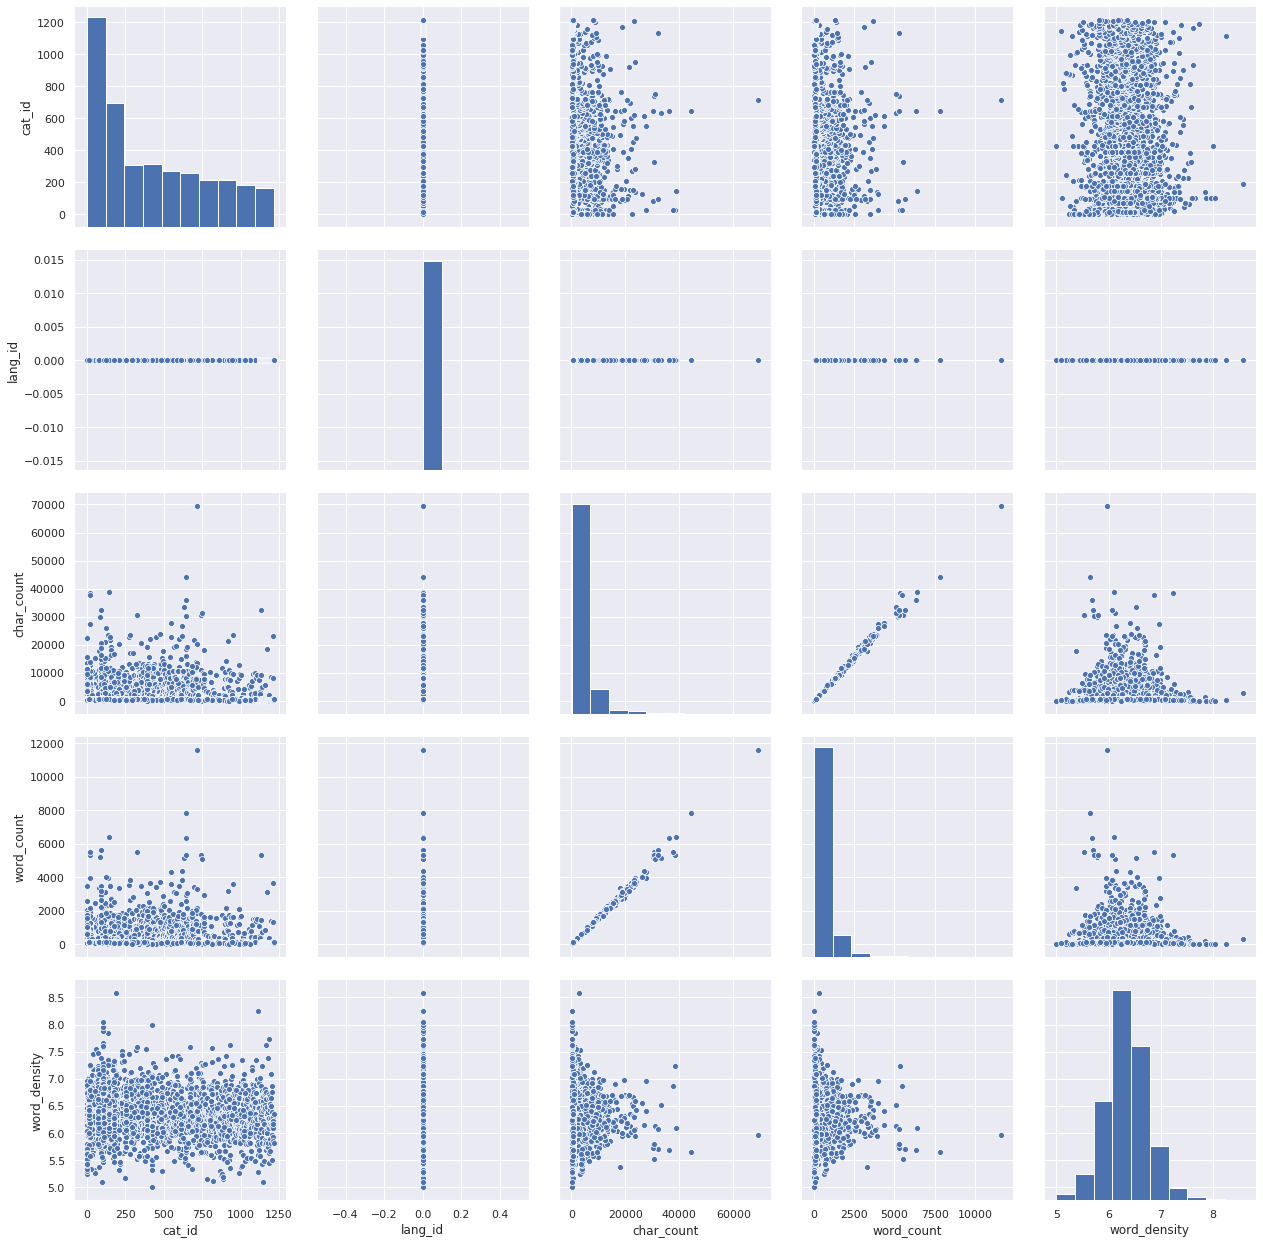

In [12]:
sns.set()
sns.pairplot(df, height=3.5)

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.33, random_state=100)

In [14]:
tfidf = TfidfVectorizer(use_idf=False, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [15]:
features = tfidf.fit_transform(df.body).toarray()
labels = df.cat_id
print(len(features), len(labels), len(df.index))

2367 2367 2367


In [16]:
engines = [
           ('PAC', PassiveAggressiveClassifier(fit_intercept=True)),
           ('RC', RidgeClassifier()),
           ('RCCV', RidgeClassifierCV()),
           ('LR', LogisticRegression(solver='lbfgs', multi_class='multinomial')),
           ('Perp', Perceptron()), 
           ('CompNB', ComplementNB()), 
           ('NC', NearestCentroid()), 
           ('MNB', MultinomialNB(alpha=.01)), 
           ('RFC', RandomForestClassifier(min_samples_leaf=.01))
          ]

In [17]:
for name, engine in engines:
  clf = make_pipeline(tfidf, engine)
  clf.fit(xtrain, ytrain)
  prediction = clf.predict(xtest)
  score = clf.score(xtest, prediction)
  print(name, score)
  # print("Accuracy: {:.2f}%".format(accuracy_score(ytest, prediction) * 100))
  with open('./data/{}.pickle'.format(name.lower()), 'wb') as f:
    pickle.dump(clf, f)

PAC 1.0
RC 1.0
RCCV 1.0
LR 1.0
Perp 1.0
CompNB 1.0
NC 1.0
MNB 1.0
RFC 1.0


In [18]:
s = '''

‘Guys, you’ve got to hear this,” I said. I was sitting in front of my computer one day in July 2012, with one eye on a screen of share prices and the other on a live stream of the House of Commons Treasury select committee hearings. As the Barclays share price took a graceful swan dive, I pulled my headphones out of the socket and turned up the volume so everyone could hear. My colleagues left their terminals and came around to watch BBC Parliament with me.

It didn’t take long to realise what was happening. “Bob’s getting murdered,” someone said.

Bob Diamond, the swashbuckling chief executive of Barclays, had been called before the committee to explain exactly what his bank had been playing at in regards to the Libor rate-fixing scandal. The day before his appearance, he had made things very much worse by seeming to accuse the deputy governor of the Bank of England of ordering him to fiddle an important benchmark, then walking back the accusation as soon as it was challenged. He was trying to turn on his legendary charm in front of a committee of angry MPs, and it wasn’t working. On our trading floor, in Mayfair, calls were coming in from all over the City. Investors needed to know what was happening and whether the damage was reparable.

A couple of weeks later, the damage was done. The money was gone, Diamond was out of a job and the market, as it always does, had moved on. We were left asking ourselves: How did we get it so wrong?

'''

In [19]:
result = []
for file in glob.glob('./data/*.pickle'):
  clf = pickle.load(open('{}'.format(file), 'rb'))
  say = clf.predict([s])
  score = clf.score([s], say)
  print(file, say[0], score)
  result.append(say[0])

print(dumps(Counter(result), indent=4))

./data/nc.pickle Opinion 1.0
./data/mnb.pickle Opinion 1.0
./data/compnb.pickle Opinion 1.0
./data/pac.pickle Opinion 1.0
./data/perp.pickle Opinion 1.0
./data/lr.pickle Opinion 1.0
./data/rc.pickle Opinion 1.0
./data/rfc.pickle Opinion 1.0
./data/rccv.pickle Opinion 1.0
{
    "Opinion": 9
}
